# miniGMG
miniGMG is a compact benchmark for understanding the performance challenges associated with geometric multigrid solvers found in applications built from AMR MG frameworks like CHOMBO or BoxLib when running on modern multi- and manycore-based supercomputers.  It includes both productive reference examples as well as highly-optimized implementations for CPUs and GPUs.  It is sufficiently general that it has been used to evaluate a broad range of research topics including PGAS programming models and algorithmic tradeoffs inherit in multigrid.  

    
Note, miniGMG code has been supersceded by HPGMG.

---
## Parameters
```
Compiler = icc (ICC) 18.0.1 20171018
Compiler = clang 7.0.0
Build_Flags = -g -O3 -march=native
Run_Parameters = 8 2 2 2 1 1 1
```

---
## Scaling

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

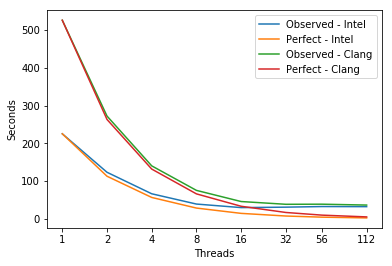

In [4]:
# Plot Measurements
Threads = [1,2,4,8,16,32,56,112]
fig, ax = plt.subplots(); ax.set_xscale('log', basex=2); ax.set_xticks(Threads)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.plot(Threads,[225.0, 123.0, 66.0, 38.75, 29.375, 30.53125, 32.14285714285714, 31.875],
        label='Observed - Intel')
ax.plot(Threads, [225.0, 112.5, 56.25, 28.125, 14.0625, 7.03125, 4.017857142857143, 2.0089285714285716],
        label='Perfect - Intel')

ax.plot(Threads,[526.0, 272.0, 140.0, 75.0, 45.4375, 38.125, 38.39285714285714, 36.07142857142858],
        label='Observed - Clang')
ax.plot(Threads, [526.0, 263.0, 131.5, 65.75, 32.875, 16.4375, 9.392857142857142, 4.696428571428571],
        label='Perfect - Clang')

ax.legend(); ax.set_xlabel('Threads'); ax.set_ylabel('Seconds')
plt.show()

---
## Roofline  -  Intel(R) Xeon(R) CPU E5-2699 v3 @ 2.30GHz Fix
### 72 Threads - 36 - Cores 2300.0 Mhz  WRONG ONE RIGHT NOW Fix
|     GB/sec     |  L1 B/W |  L2 B/W |  L3 B/W | DRAM B/W |
|:---------------|:-------:|:-------:|:-------:|:--------:|
|**1 Thread**    |  229.54 |  131.55 |    53.4 |    23.05 |
|**56 Threads**  | 4965.38 | 3156.15 |  ?? |   174.23 |
|**112 Threads** | 5007.03 | 3235.59 |  ?? |   179.26  |

---
## Intel Software Development Emulator 
| SDE Metrics | Intel | Clang |
|:-----------|:---:|:---:|
| **Arithmetic Intensity** | 0.13 | 0.11 |
| **Bytes per Load Inst** | 17.94 | 7.91 |
| **Bytes per Store Inst** | 9.31 | 7.71 |
| **FLOPS per Inst** | 1.19 | 0.42 |

---
## Experiment Aggregate Metrics
 |Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|OFFCORE => 6|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| **Intel** |
|1 (100.0%)|0.78|0.39|0.33|20.64%|51.89%|79.55%|3.91%|9.03%|0.65%|95.01%|
|56 (100.0%)|0.23|0.10|0.11|12.65%|55.63%|90.61%|1.61%|0.00%|1.26%|91.10%|
|112 (100.0%)|0.71|0.14|0.08|17.80%|51.04%|89.96%|3.36%|0.00%|1.56%|92.81%|
| **Clang** |
|1 (100.0%)|1.88|0.77|0.84|4.40%|44.80%|61.10%|2.68%|5.73%|0.03%|54.34%|
|56 (100.0%)|0.72|0.29|0.33|3.87%|51.52%|79.77%|2.13%|0.00%|0.56%|85.26%|
|112 (100.0%)|1.70|0.34|0.19|7.37%|48.90%|84.67%|4.75%|0.00%|1.29%|87.85%|

---
### Jacobi
```c
  9 void smooth(domain_type * domain, int level, int phi_id, int rhs_id, double a, double b){
 10   if(numSmooths&1){
 11     printf("error - numSmooths must be even...\n");
 12     exit(0);
 13   }
 14 
 15   int CollaborativeThreadingBoxSize = 100000; // i.e. never
 16   #ifdef __COLLABORATIVE_THREADING
 17     CollaborativeThreadingBoxSize = 1 << __COLLABORATIVE_THREADING;
 18   #endif
 19   int omp_across_boxes = (domain->subdomains[0].levels[level].dim.i <  CollaborativeThreadingBoxSize);
 20   int omp_within_a_box = (domain->subdomains[0].levels[level].dim.i >= CollaborativeThreadingBoxSize);
 21 
 22   int box,s;
 23   int ghosts = domain->ghosts;
 24   double TwoThirds = 2.0/3.0;
 25 
 26   // if communication-avoiding, need RHS for stencils in ghost zones
 27   if(ghosts>1)exchange_boundary(domain,level,rhs_id,1,1,1);
 28 
 29   for(s=0;s<numSmooths;s+=ghosts){
 30     // Jacobi ping pongs between phi and __temp
 31     if((s&1)==0)exchange_boundary(domain,level,phi_id,1,ghosts>1,ghosts>1);  // corners/edges if doing communication-avoiding...
 32            else exchange_boundary(domain,level,__temp,1,ghosts>1,ghosts>1);  // corners/edges if doing communication-avoiding...
 33 
 34     // now do ghosts communication-avoiding smooths on each box...
 35     uint64_t _timeStart = CycleTime();
 36 
 37     #pragma omp parallel for private(box) if(omp_across_boxes)
 38     for(box=0;box<domain->subdomains_per_rank;box++){
 39       int i,j,k,ss;
 40       int pencil = domain->subdomains[box].levels[level].pencil;
 41       int  plane = domain->subdomains[box].levels[level].plane;
 42       int ghosts = domain->subdomains[box].levels[level].ghosts;
 43       int  dim_k = domain->subdomains[box].levels[level].dim.k;
 44       int  dim_j = domain->subdomains[box].levels[level].dim.j;
 45       int  dim_i = domain->subdomains[box].levels[level].dim.i;
 46       double h2inv = 1.0/(domain->h[level]*domain->h[level]);
 47       double * __restrict__ rhs    = domain->subdomains[box].levels[level].grids[  rhs_id] + ghosts*(1+pencil+plane);
 48       double * __restrict__ alpha  = domain->subdomains[box].levels[level].grids[__alpha ] + ghosts*(1+pencil+plane);
 49       double * __restrict__ beta_i = domain->subdomains[box].levels[level].grids[__beta_i] + ghosts*(1+pencil+plane);
 50       double * __restrict__ beta_j = domain->subdomains[box].levels[level].grids[__beta_j] + ghosts*(1+pencil+plane);
 51       double * __restrict__ beta_k = domain->subdomains[box].levels[level].grids[__beta_k] + ghosts*(1+pencil+plane);
 52       double * __restrict__ lambda = domain->subdomains[box].levels[level].grids[__lambda] + ghosts*(1+pencil+plane);
 53 
 54       int ghostsToOperateOn=ghosts-1;
 55       for(ss=s;ss<s+ghosts;ss++,ghostsToOperateOn--){
 56         double * __restrict__ phi;
 57         double * __restrict__ phi_new;
 58               if((ss&1)==0){phi    = domain->subdomains[box].levels[level].grids[  phi_id] + ghosts*(1+pencil+plane);
 59                             phi_new= domain->subdomains[box].levels[level].grids[  __temp] + ghosts*(1+pencil+plane);}
 60                        else{phi    = domain->subdomains[box].levels[level].grids[  __temp] + ghosts*(1+pencil+plane);
 61                             phi_new= domain->subdomains[box].levels[level].grids[  phi_id] + ghosts*(1+pencil+plane);}
 ```
 
  |Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|OFFCORE => 6|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| **Intel** |
|1 (68.7%)|0.75|0.42|0.35|21.50%|50.89%|71.19%|4.30%|9.87%|0.31%|99.48%|
|56 (55.6%)|0.14|0.08|0.07|22.17%|54.67%|89.16%|2.01%|0.00%|1.05%|99.01%|
|112 (50.2)|0.33|0.08|0.02|48.36%|50.61%|90.37%|4.30%|0.00%|1.68%|97.28%|
| **Clang** |
|1 (41.2%)|1.90|1.14|1.12|5.90%|43.93%|27.18%|4.85%|10.43%|0.01%|99.29%|
|56 (47.7%)|0.51|0.31|0.30|5.85%|51.33%|81.74%|3.04%|0.00%|0.78%|98.54%|
|112 (44.5%)|1.05|0.33|0.15|12.59%|49.40%|87.57%|6.81%|0.00%|2.08%|96.68%|
 
 ```c
 62         #pragma omp parallel for private(k,j,i) if(omp_within_a_box) collapse(2)
 63         for(k=0-ghostsToOperateOn;k<dim_k+ghostsToOperateOn;k++){
 64         for(j=0-ghostsToOperateOn;j<dim_j+ghostsToOperateOn;j++){
 65         for(i=0-ghostsToOperateOn;i<dim_i+ghostsToOperateOn;i++){
 66           int ijk = i + j*pencil + k*plane;
 67           double helmholtz =  a*alpha[ijk]*phi[ijk]
 68                              -b*h2inv*(
 69                                 beta_i[ijk+1     ]*( phi[ijk+1     ]-phi[ijk       ] )
 70                                -beta_i[ijk       ]*( phi[ijk       ]-phi[ijk-1     ] )
 71                                +beta_j[ijk+pencil]*( phi[ijk+pencil]-phi[ijk       ] )
 72                                -beta_j[ijk       ]*( phi[ijk       ]-phi[ijk-pencil] )
 73                                +beta_k[ijk+plane ]*( phi[ijk+plane ]-phi[ijk       ] )
 74                                -beta_k[ijk       ]*( phi[ijk       ]-phi[ijk-plane ] )
 75                               );
 76           phi_new[ijk] = phi[ijk] - TwoThirds*lambda[ijk]*(helmholtz-rhs[ijk]);
 77         }}}
 78       } // ss-loop
 79     } // box-loop
 80     domain->cycles.smooth[level] += (uint64_t)(CycleTime()-_timeStart);
 81   } // s-loop
 82 }

```

---
### Residual
```c
  9 void residual(domain_type * domain, int level,  int res_id, int phi_id, int rhs_id, double a, double b){
 10   // exchange the boundary for x in prep for Ax...
 11   // for 7-point stencil, only needs to be a 1-deep ghost zone & faces only
 12   exchange_boundary(domain,level,phi_id,1,0,0);
 13 
 14   // now do residual/restriction proper...
 15   uint64_t _timeStart = CycleTime();
 16   int CollaborativeThreadingBoxSize = 100000; // i.e. never
 17   #ifdef __COLLABORATIVE_THREADING
 18     CollaborativeThreadingBoxSize = 1 << __COLLABORATIVE_THREADING;
 19   #endif
 20   int omp_across_boxes = (domain->subdomains[0].levels[level].dim.i <  CollaborativeThreadingBoxSize);
 21   int omp_within_a_box = (domain->subdomains[0].levels[level].dim.i >= CollaborativeThreadingBoxSize);
 22   int box;
 23 
 24   #pragma omp parallel for private(box) if(omp_across_boxes)
 25   for(box=0;box<domain->subdomains_per_rank;box++){
 26     int i,j,k;
 27     int pencil = domain->subdomains[box].levels[level].pencil;
 28     int  plane = domain->subdomains[box].levels[level].plane;
 29     int ghosts = domain->subdomains[box].levels[level].ghosts;
 30     int  dim_k = domain->subdomains[box].levels[level].dim.k;
 31     int  dim_j = domain->subdomains[box].levels[level].dim.j;
 32     int  dim_i = domain->subdomains[box].levels[level].dim.i;
 33     double h2inv = 1.0/(domain->h[level]*domain->h[level]);
 34     double * __restrict__ phi    = domain->subdomains[box].levels[level].grids[  phi_id] + ghosts*(1+pencil+plane); // i.e. [0] = first non ghost zone point
 35     double * __restrict__ rhs    = domain->subdomains[box].levels[level].grids[  rhs_id] + ghosts*(1+pencil+plane);
 36     double * __restrict__ alpha  = domain->subdomains[box].levels[level].grids[__alpha ] + ghosts*(1+pencil+plane);
 37     double * __restrict__ beta_i = domain->subdomains[box].levels[level].grids[__beta_i] + ghosts*(1+pencil+plane);
 38     double * __restrict__ beta_j = domain->subdomains[box].levels[level].grids[__beta_j] + ghosts*(1+pencil+plane);
 39     double * __restrict__ beta_k = domain->subdomains[box].levels[level].grids[__beta_k] + ghosts*(1+pencil+plane);
 40     double * __restrict__ res    = domain->subdomains[box].levels[level].grids[  res_id] + ghosts*(1+pencil+plane);
 41 
 ```
 
   |Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|OFFCORE => 6|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| **Intel** |
|1 (14.3%)|0.85|0.42|0.34|21.93%|51.41%|68.72%|4.39%|10.03%|0.34%|99.38%|
|56 (11.7%)|0.16|0.08|0.07|22.59%|54.78%|90.16%|2.05%|0.00%|1.25%|99.05%|
|112 (10.7%)|0.35|0.08|0.02|49.80%|50.00%|90.58%|4.24%|0.00%|1.71%|97.38%|
| **Clang** |
|1 (8.2%)|2.08|1.20|1.18|6.16%|44.63%|18.46%|5.34%|11.77%|0.01%|99.06%|
|56 (10.3%)|0.50|0.29|0.28|6.27%|51.03%|82.37%|3.06%|0.00%|0.86%|99.54%|
|112 (9.6%)|1.03|0.31|0.14|13.42%|49.13%|87.67%|6.83%|0.00%|2.11%|96.99%|
 
 ```c
 42     #pragma omp parallel for private(k,j,i) if(omp_within_a_box) collapse(2)
 43     for(k=0;k<dim_k;k++){
 44     for(j=0;j<dim_j;j++){
 45     for(i=0;i<dim_i;i++){
 46       int ijk = i + j*pencil + k*plane;
 47       double helmholtz =  a*alpha[ijk]*phi[ijk]
 48                          -b*h2inv*(
 49                             beta_i[ijk+1     ]*( phi[ijk+1     ]-phi[ijk       ] )
 50                            -beta_i[ijk       ]*( phi[ijk       ]-phi[ijk-1     ] )
 51                            +beta_j[ijk+pencil]*( phi[ijk+pencil]-phi[ijk       ] )
 52                            -beta_j[ijk       ]*( phi[ijk       ]-phi[ijk-pencil] )
 53                            +beta_k[ijk+plane ]*( phi[ijk+plane ]-phi[ijk       ] )
 54                            -beta_k[ijk       ]*( phi[ijk       ]-phi[ijk-plane ] )
 55                           );
 56       res[ijk] = rhs[ijk]-helmholtz;
 57     }}}
 58   }
 59   domain->cycles.residual[level] += (uint64_t)(CycleTime()-_timeStart);
 60 }
```

## Stencil - Latency Bound
High miss rates